In [1]:
import time
import os, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy.linalg import multi_dot, inv
import torch

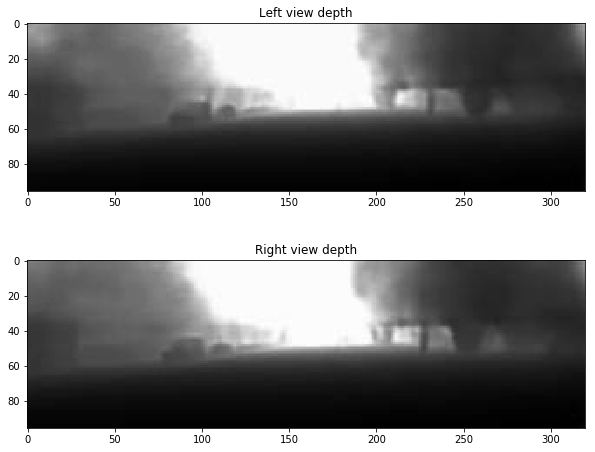

(torch.Size([1, 96, 320]),
 tensor(0.8235, dtype=torch.float64, device='cuda:0'),
 tensor(1.00000e-02 *
        6.2745, dtype=torch.float64, device='cuda:0'))

In [2]:
depth_l = mpimg.imread('./example_data/consistency/left/0000000000.jpg')
depth_r = mpimg.imread('./example_data/consistency/right/0000000000.jpg')
f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
ax1.set_title('Left view depth')
ax1.imshow(depth_l, cmap='gray')
ax2.set_title('Right view depth')
ax2.imshow(depth_r, cmap='gray')
plt.show()
l = torch.tensor(depth_l / 255).unsqueeze(0).cuda()
r = torch.tensor(depth_r / 255).unsqueeze(0).cuda()
l.shape, l.max(), l.min()

In [3]:
class Reconstruction():
    def __init__(self, date, scaling=1):
        self.date = date
        self.scaling = scaling
        self.K2R2_K3 = None
        self.K3R3C3 = None
        self.K3R3_K2 = None
        self.K2R2C2 = None
        self._get_transformations()
        
    def _get_transformations(self):
        if self.date=='2011_09_26':
            self.K2 = np.array([[9.597910e+02, 0.000000e+00, 6.960217e+02],
                               [0.000000e+00, 9.569251e+02, 2.241806e+02],
                               [0.000000e+00, 0.000000e+00, 1.000000e+00]])
            self.K3 = np.array([[9.037596e+02, 0.000000e+00, 6.957519e+02],
                               [0.000000e+00, 9.019653e+02, 2.242509e+02],
                               [0.000000e+00, 0.000000e+00,1.000000e+00]])
            self.R2 = np.array([[ 9.999758e-01, -5.267463e-03, -4.552439e-03],
                                [ 5.251945e-03,  9.999804e-01, -3.413835e-03],
                                [ 4.570332e-03,  3.389843e-03,  9.999838e-01]])
            self.t2 = np.array([[ 5.956621e-02],
                                [ 2.900141e-04],
                                [ 2.577209e-03]])
            self.R3 = np.array([[ 9.995599e-01,  1.699522e-02, -2.431313e-02],
                                [-1.704422e-02,  9.998531e-01, -1.809756e-03],
                                [ 2.427880e-02,  2.223358e-03,  9.997028e-01]])
            self.t3 = np.array([[-4.731050e-01], 
                                [ 5.551470e-03],
                                [-5.250882e-03]])
            
        #Dollhouse scaling
        self.K3 = self.K3 * self.scaling
        self.K2 = self.K2 * self.scaling
        self.K3[2][2] = 1
        self.K2[2][2] = 1
        self.t2 = self.t2 * self.scaling
        self.t3 = self.t3 * self.scaling
        #L2R
        dR = np.eye(3) #No rotation
        self.K3R3_K2 = multi_dot([self.K3, dR, inv(self.K2)])
        self.K3R3C3 = multi_dot([self.K3, dR, (self.t2 - self.t3)])
        #R2L
        self.K2R2_K3 = multi_dot([self.K2, dR, inv(self.K3)])
        self.K2R2C2 = multi_dot([self.K2, dR, (self.t3 - self.t2)])
        #cuda
        self.K3R3_K2 = torch.tensor(self.K3R3_K2).float().cuda()
        self.K2R2_K3 = torch.tensor(self.K2R2_K3).float().cuda()
        self.K3R3C3 = torch.tensor(self.K3R3C3).float().cuda()
        self.K2R2C2 = torch.tensor(self.K2R2C2).float().cuda()
        
    def _remap(self, p2, Zw, direction):
        p2 = p2.float().cuda()
        m2 = (Zw*p2)
        
        if direction == 'L2R':
            m1 = self.K3R3_K2
            p3 = torch.mm(m1, m2) - self.K3R3C3
            return (p3[0]/p3[2]).long(), (p3[1]/p3[2]).long()
            
        elif direction == 'R2L':
            m1 = torch.tensor(self.K2R2_K3).float().cuda()
            p3 = torch.mm(m1, m2) - torch.tensor(self.K2R2C2).float().cuda()
            return (p3[0]/p3[2]).long(), (p3[1]/p3[2]).long()
    
    def _reconstruct(self, depth_map, src_image, direction, depth_max=120.0):
        
        canvas = torch.zeros_like(depth_map) #1*96*320
        
        for x in range(src_image.shape[2]): #width
            for y in range(src_image.shape[1]):
                ptz = torch.tensor(depth_map[0][y][x]).float()
                scale = torch.tensor(depth_max*self.scaling).cuda()
                p3_x, p3_y = self._remap(p2=torch.tensor([[x], [y], [1]]), 
                                         Zw=torch.tensor(ptz * scale),
                                         direction=direction)

                xloc, yloc = int(p3_x.cpu()), int(p3_y.cpu())
                if(0 <= xloc < src_image.shape[2] and 0 <= yloc < src_image.shape[1]):
                    canvas[0][yloc][xloc] = src_image[0][y][x]

        return canvas
    
    def _recon_loss(self, tar, syn):

        tar_np = np.transpose(tar.cpu().numpy().squeeze())
        tar_np = cv2.resize(tar_np, (syn.shape[2], syn.shape[1]))
        tar = torch.tensor(tar_np).unsqueeze(0).float().cuda()

        dev = (tar - syn.float())
        loss = torch.sum(dev*dev) / (tar.shape[2]*tar.shape[1])
        
        return loss

    def compute_loss(self, depth_map, src_image, tar_image, direction):
        syn_image = self._reconstruct(depth_map=depth_map, src_image=src_image, direction=direction)
        loss = self._recon_loss(tar=tar_image, syn=syn_image)
        return loss, syn_image

In [4]:
sc = 320/1242
rf = Reconstruction(date='2011_09_26',scaling=sc)

In [5]:
loss, img = rf.compute_loss(l, l, r, 'L2R')
loss

tensor(1.00000e-02 *
       7.2919, device='cuda:0')

In [6]:
npl = img.cpu().numpy().squeeze()
ref = r.cpu().numpy().squeeze()

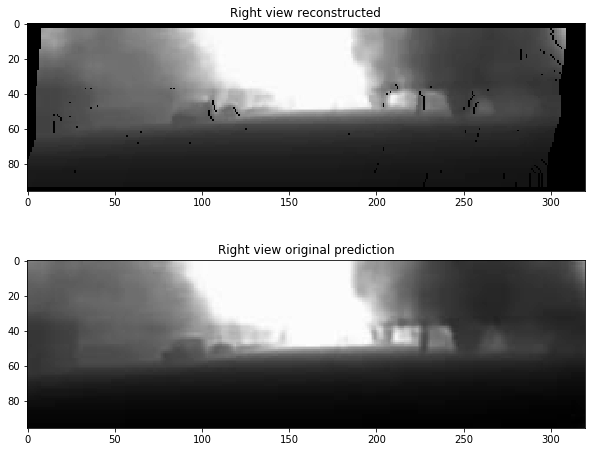

In [7]:
f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
ax1.set_title('Right view reconstructed')
ax1.imshow(npl, cmap='gray')
ax2.set_title('Right view original prediction')
ax2.imshow(ref, cmap='gray')
plt.show()